<a href="https://colab.research.google.com/github/JamorMoussa/Topic-Modeling-With-BERTopic/blob/main/00_Analyzing_Customer_Feedback_using_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Customer Feedback using Topic Modelling

**Objective:** Identify problems being faced by users from OLA app’s playstore reviews.

**Dataset:** Google playstore reviews of OLA [download from kaggle](https://www.kaggle.com/datasets/khushipitroda/ola-vs-uber-play-store-reviews)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf

## 01. About The Dataset

### 1.1 Description

This dataset contains Play Store reviews for two prominent car services, Uber and Ola. It provides valuable insights into user experiences, feedback, and sentiments towards these ride-sharing apps. The dataset includes various attributes such as review ID, user name, review title, review description, rating, thumbs up count, review date, developer response, developer response date, app version, language code, and country code. The dataset is a valuable resource for analyzing user sentiments, trends, and contributing factors that impact user satisfaction.

In [6]:
!kaggle datasets download -d khushipitroda/ola-vs-uber-play-store-reviews

Dataset URL: https://www.kaggle.com/datasets/khushipitroda/ola-vs-uber-play-store-reviews
License(s): other
ola-vs-uber-play-store-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

'Ola Customer Reviews.csv'	      sample_data
 ola-vs-uber-play-store-reviews.zip  'Uber Customer Reviews.csv'


In [8]:
!unzip ola-vs-uber-play-store-reviews.zip

Archive:  ola-vs-uber-play-store-reviews.zip
replace Ola Customer Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Uber Customer Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## 02. Exploratory Data Analysis - EDA

### 2.1 Eplore The Dataset

In [9]:
ola_df = pd.read_csv("/content/Ola Customer Reviews.csv")
ola_df.columns

<ipython-input-9-4aa1c64f3d96>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ola_df = pd.read_csv("/content/Ola Customer Reviews.csv")


Index(['source', 'review_id', 'user_name', 'review_title',
       'review_description', 'rating', 'thumbs_up', 'review_date',
       'developer_response', 'developer_response_date', 'appVersion',
       'laguage_code', 'country_code'],
      dtype='object')

In [10]:
ola_df.head(1)

,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,Google Play,fbc7ffc9-5a89-446e-87fd-d69bf4a7f984,Puipuii Ralte,NaN,"The map in Ola is so messed up, i have to pay ...",1,0.0,2023-08-10 16:40:50,NaN,NaN,6.3.2,en,in


The total rows is `357698`

In [11]:
ola_df.shape

(357698, 13)

For our study, for instance we are interested with `review_description`. As we can see that we have some `NaN` in the `review descption` column.

In [12]:
ola_df.isna().sum()

,0
source,0
review_id,0
user_name,0
review_title,356807
review_description,20
rating,0
thumbs_up,891
review_date,0
developer_response,232929
developer_response_date,233108


As we can see that all reviews are in English, this is an important information, later when we will use an Embedding Model.

In [13]:
ola_df["laguage_code"].value_counts()

,count
laguage_code,
en,357698


In [14]:
ola_df["rating"].value_counts()

,count
rating,
1,173200
5,127957
4,24964
3,15991
2,15586


<Axes: ylabel='count'>

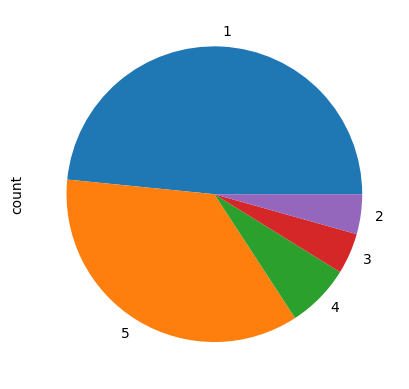

In [15]:
ola_df["rating"].value_counts().plot.pie()

In [16]:
app_version = ola_df["appVersion"].value_counts().reset_index()
app_version.head(5)

,appVersion,count
0,5.5.5,7718
1,5.5.1,6445
2,5.5.2,5306
3,5.6.6,5260
4,4.7.8,4684


### 2.2 Keep importants Features

In [17]:
ola_df.columns

Index(['source', 'review_id', 'user_name', 'review_title',
       'review_description', 'rating', 'thumbs_up', 'review_date',
       'developer_response', 'developer_response_date', 'appVersion',
       'laguage_code', 'country_code'],
      dtype='object')

In [18]:
keep_cols = ["review_description", "rating", "review_date"]

In [19]:
data = ola_df.loc[:, keep_cols]

In [20]:
data.head(10)

,review_description,rating,review_date
0,"The map in Ola is so messed up, i have to pay ...",1,2023-08-10 16:40:50
1,Deepak Kumar.... 🙏🙏🙏🙏🙏],5,2023-08-10 16:36:14
2,Such aa irresponsible app more then I waiting ...,1,2023-08-10 16:29:31
3,Worst,1,2023-08-10 15:52:06
4,Too much expensive .. try UBer... They are pro...,1,2023-08-10 15:51:10
5,Ola drivers demanding extra money for ride.......,2,2023-08-10 15:46:30
6,Pathetic service. No option to contact with th...,1,2023-08-10 15:14:25
7,No proper support from OLA. Simply asking us t...,1,2023-08-10 15:03:45
8,"Fraud app ,everytime the estimated fare and fi...",1,2023-08-10 14:54:47
9,The driver doesn't pick the phone and they are...,1,2023-08-10 14:31:49


### 2.3 Remove Missing values

In [21]:
data.isna().sum()

,0
review_description,20
rating,0
review_date,0


In [22]:
data = data.dropna(subset=["review_description"])

### 2.4 Review Text Processing

In [23]:
def preprocess_text(text):
    # Convert to lowercase
    text = tf.strings.lower(text)

    # Remove HTML tags
    text = tf.strings.regex_replace(text, r'<.*?>', '')

    # Remove non-alphabet characters
    text = tf.strings.regex_replace(text, r'[^a-zA-Z\s]', '')

    # Strip leading and trailing whitespaces
    text = tf.strings.strip(text)
    return text.numpy().decode('utf-8')

In [24]:
data["cleaned_review"] = data["review_description"].apply(lambda x: preprocess_text(tf.convert_to_tensor(x)))

In [25]:
data["review_length"] = data["cleaned_review"].apply(lambda x: len(tuple(x)))

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357678 entries, 0 to 357697
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   review_description  357678 non-null  object
 1   rating              357678 non-null  int64 
 2   review_date         357678 non-null  object
 3   cleaned_review      357678 non-null  object
 4   review_length       357678 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 16.4+ MB


In [27]:
data["review_length"].describe()

,review_length
count,357678.000000
mean,88.819153
std,121.153551
min,0.000000
25%,8.000000
50%,31.000000
75%,126.000000
max,2791.000000


<Axes: xlabel='review_length', ylabel='Count'>

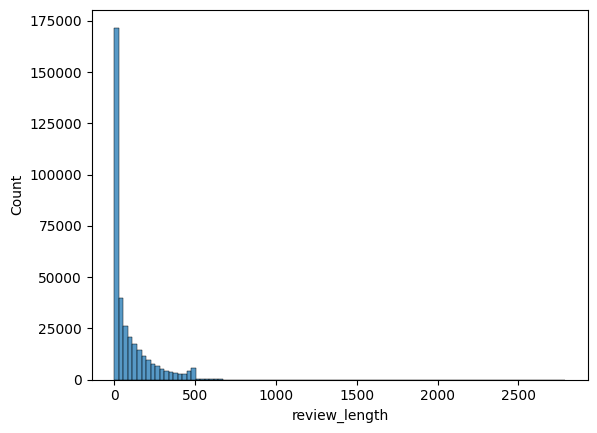

In [28]:
sns.histplot(data["review_length"], bins=100)

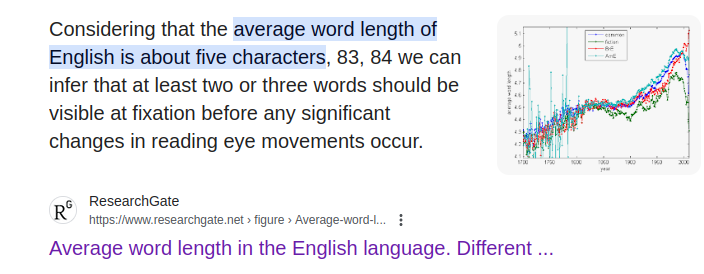

The figure above gives that average word in english is 5 characters. we choose that we keep 5x words for each review. from the review length distribution we can see that the length the most review are less than 500.

In [29]:
data = data[(data["review_length"] >= 25) & (data["review_length"] <= 500)]

<Axes: xlabel='review_length', ylabel='Count'>

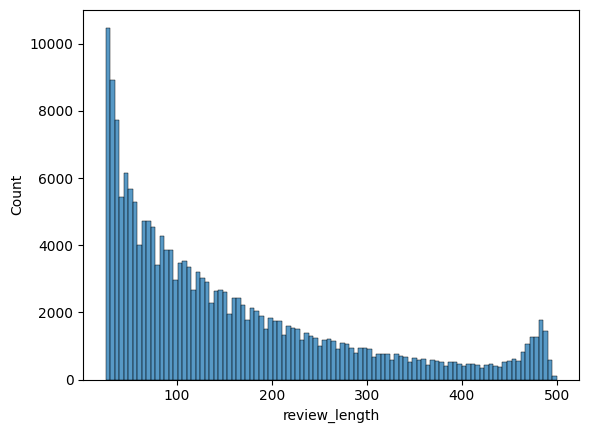

In [30]:
sns.histplot(data["review_length"], bins=100)

In [ ]:
!pip install bertopic

In [32]:
from bertopic import BERTopic

In [36]:
bert_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

In [37]:
bert_model

In [ ]:
topics, probs = bert_model.fit(data["cleaned_review"])

2024-10-13 01:05:14,309 - BERTopic - Embedding - Transforming documents to embeddings.


model.safetensors:  35%|###4      | 31.5M/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/5990 [00:00<?, ?it/s]

2024-10-13 01:07:08,741 - BERTopic - Embedding - Completed ✓
2024-10-13 01:07:08,744 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-10-13 01:12:10,351 - BERTopic - Dimensionality - Completed ✓
2024-10-13 01:12:10,357 - BERTopic - Cluster - Start clustering the reduced embeddings
